In [57]:
#dependencies
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from numpy import array
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelBinarizer

In [58]:
def load_data(filename,encoding):
    data = pd.read_csv(filename,encoding=encoding)
    return data

def create_train_test_sets(data,split):
    np.random.seed(0)
    mask = np.random.rand(len(data)) < split
    train_data = data[mask]
    test_data = data[~mask]
    return train_data,test_data

def clean_and_get_tokens(doc):
    tokens = doc.split()
    table = str.maketrans('','',punctuation)  #removes punctuations using 
    tokens = [w.translate(table) for w in tokens] #dictionary of punctuations
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word)>2]
    return tokens

In [59]:
data = load_data('bbc/BBC_news.csv','latin1')
words = set()
vocab = {}


token = data['texts'][0].split()
table = str.maketrans('','',punctuation)
tokens = [w.translate(table) for w in token] 
#print(tokens)
tokens = [word for word in tokens if word.isalpha()]
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
tokens = [word for word in tokens if len(word)>2]
#print(tokens)

documents = data['texts']
for doc in documents:
    tokens = clean_and_get_tokens(doc)
    for token in tokens:
        if token in vocab:
            vocab[token] += 1
        else:
            vocab[token] = 1

for word in vocab:
    if vocab[word] > 5:
        words.add(word)



train_data,test_data = create_train_test_sets(data,0.8)

train_documents = []
for doc in train_data['texts']:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    final_string = ' '.join(final_tokens)
    train_documents.append(final_string)

test_documents = []
for doc in test_data['texts']:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    final_string = ' '.join(final_tokens)
    test_documents.append(final_string)



In [75]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_documents)
encoded_docs = tokenizer.texts_to_sequences(train_documents)

max_length = max(([len(s.split()) for s in train_documents]))
labels = train_data['CAT']
train_labels = labels
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytrain = keras.utils.to_categorical(labels, num_classes=5)

In [61]:
encoded_docs = tokenizer.texts_to_sequences(test_documents)
labels = test_data['CAT']
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytest = keras.utils.to_categorical(labels, num_classes=5)

In [62]:
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_length))
model.add(Conv1D(filters=16, kernel_size=16, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1582, 100)         879700    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1567, 16)          25616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 783, 16)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12528)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12528)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 62645     
Total params: 967,961
Trainable params: 967,961
Non-trainable params: 0
_________________________________________________________________
None

In [63]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=5, verbose=2, validation_data = (Xtest,ytest))

Train on 1753 samples, validate on 472 samples
Epoch 1/4
 - 5s - loss: 1.5017 - acc: 0.3269 - val_loss: 1.2275 - val_acc: 0.5106
Epoch 2/4
 - 4s - loss: 0.6857 - acc: 0.7473 - val_loss: 0.3880 - val_acc: 0.8581
Epoch 3/4
 - 4s - loss: 0.0945 - acc: 0.9795 - val_loss: 0.1540 - val_acc: 0.9407
Epoch 4/4
 - 4s - loss: 0.0132 - acc: 0.9989 - val_loss: 0.1072 - val_acc: 0.9661


In [64]:
random_text = ["I love business and sports"]
encoded_text = tokenizer.texts_to_sequences(random_text)
test_text = pad_sequences(encoded_text, maxlen = max_length, padding= 'post')
model.predict(test_text)

array([[2.51485017e-06, 1.20323235e-02, 2.25236538e-04, 9.87738907e-01,
        9.65116442e-07]], dtype=float32)

In [65]:
ypred = model.predict(Xtest)
pred_labels = []
for probs in ypred:
    label = np.argmax(probs, axis=-1)
    pred_labels.append(int(label))
actual_labels = list(labels)

In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, pred_labels)

Text(0.5,15,'Predicted label')

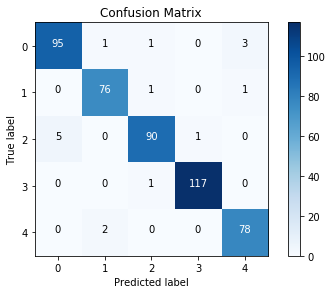

In [67]:
import matplotlib.pyplot as plt
import itertools
cmap = plt.cm.Blues
title = "Confusion Matrix"
classes = 5
normalize = False
tick_marks = np.arange(classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(5)
#plt.xticks(tick_marks, classes, rotation=45)
#plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()